<a href="https://colab.research.google.com/github/mariamelghandoor/ADAM-optimizer-/blob/main/ADAM_Optimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import numpy as np
import math
import time
import matplotlib.pyplot as plt

# Helper functions

In [ ]:
def grad_rosenbrock(x):
  x1, x2 = x
  grad = np.array([
      -400 * (x2 - x1**2) * x1 - 2 * (1 - x1),
      200 * (x2 - x1**2)
  ])
  return grad

In [ ]:
def H_rosenbrock(x):
  x1, x2 = x
  hessian = np.array([
      [1200 * x1**2 - 400 * x2 + 2, -400 * x1],
      [-400 * x1, 200]
  ])
  return hessian

In [ ]:
def rosenbrock(x):
  x1, x2 = x
  return 100 * (x2 - x1**2)**2 + (1 - x1)**2

In [ ]:
def grad_powell(x):
  x1, x2, x3, x4 = x
  grad = np.array([
    2 * (x1 + 10 * x2) + 40 * (x1 - x4)**3,
    20 * (x1 + 10 * x2) + 4 * (x2 - 2 * x3)**3,
    10 * (x3 - x4) - 8 * (x2 - 2 * x3)**3,
    -10 * (x3 - x4) - 40 * (x1 - x4)**3
  ])
  return grad

In [ ]:
def H_powell(x):
  x1, x2, x3, x4 = x
  hessian = np.zeros((4, 4))
  hessian[0, 0] = 2 + 120 * (x1 - x4)**2
  hessian[0, 1] = hessian[1, 0] = 20
  hessian[0, 3] = hessian[3, 0] = -120 * (x1 - x4)**2
  hessian[1, 1] = 200 + 12 * (x2 - 2 * x3)**2
  hessian[1, 2] = hessian[2, 1] = -24 * (x2 - 2 * x3)**2
  hessian[2, 2] = 10 + 48 * (x2 - 2 * x3)**2
  hessian[2, 3] = hessian[3, 2] = -10
  hessian[3, 3] = 10 + 120 * (x1 - x4)**2
  return hessian

In [ ]:
def powell(x):
  x1, x2, x3, x4 = x
  return (x1 + 10 * x2) ** 2 + 5 * (x3 - x4) ** 2 + (x2 - 2 * x3) ** 4 + 10 * (x1 - x4) ** 4

In [ ]:
def compare_optimizers(np_results, torch_results, y_lim, y_start = 0):
    np_steps = range(1, len(np_results[2]) + 1)
    torch_steps = range(1, len(torch_results[0]) + 1)

    plt.figure(figsize=(8, 6))

    # Function value comparison
    plt.subplot(3, 1, 1)

    plt.plot(torch_steps, torch_results[0], label="PyTorch Adam", color="orange")
    plt.plot(np_steps, np_results[2], label="Numpy Adam", color="blue")
    plt.xlabel("Steps")
    plt.ylabel("Function Value")
    plt.title("Function Value vs. Steps")
    plt.ylim(y_start, y_lim)
    plt.legend()

    # Gradient norm comparison
    plt.subplot(3, 1, 2)

    plt.plot(torch_steps, torch_results[1], label="PyTorch Adam", color="orange")
    plt.plot(np_steps, np_results[3], label="Numpy Adam", color="blue")
    plt.xlabel("Steps")
    plt.ylabel("Gradient Norm")
    plt.title("Gradient Norm vs. Steps")
    plt.ylim(y_start, y_lim)
    plt.legend()



    plt.tight_layout()
    plt.show()



In [ ]:
def plot_cpu_time_comparison(numpy_time, torch_time):
    optimizers = ['Numpy Adam', 'PyTorch Adam']
    times = [numpy_time, torch_time]

    plt.figure(figsize=(6, 4))
    plt.bar(optimizers, times, color=['blue', 'orange'])
    plt.xlabel("Optimizer")
    plt.ylabel("CPU Time (seconds)")
    plt.title("CPU Time Comparison Between Numpy Adam and PyTorch Adam")
    plt.show()


# LAST modified

In [ ]:
def adam_optimizer(
    grad_fn,
    func_fn,
    x_init,
    beta1=0.9,
    beta2=0.99,
    epsilon=1e-8,
    lr_initial=0.01,
    max_grad_norm=1.0,
    convergence_criteria=(1e-4, 1e-6),
    max_steps=10000
):
    """
    Generalized Adam optimizer for minimizing a given function.

    Parameters:
    - grad_fn: Function to compute the gradient (grad_fn(x)).
    - func_fn: Function to compute the objective value (func_fn(x)).
    - x_init: Initial parameter values (numpy array).
    - beta1: Exponential decay rate for the first moment estimate.
    - beta2: Exponential decay rate for the second moment estimate.
    - epsilon: Small constant for numerical stability.
    - lr_initial: Initial learning rate.
    - max_grad_norm: Maximum norm for gradient clipping.
    - convergence_criteria: Tuple (gradient norm threshold, function value threshold).
    - max_steps: Maximum number of optimization steps.

    Returns:
    - x: Optimized parameters.
    - steps: Total number of steps taken.
    - history: List of function values at each step.
    """
    x = np.array(x_init, dtype=float)
    v = np.zeros_like(x)
    s = np.zeros_like(x)
    steps = 0
    grad_norm_threshold, func_value_threshold = convergence_criteria
    history = []
    grad_norms = []


    while steps < max_steps:
        steps += 1
        grad = grad_fn(x)

        # Gradient clipping for stability
        grad_norm = np.linalg.norm(grad)
        if grad_norm > max_grad_norm:
            grad = grad * (max_grad_norm / grad_norm)

        # Update moving averages
        v = beta1 * v + (1 - beta1) * grad
        s = beta2 * s + (1 - beta2) * (grad**2)

        # Bias-corrected estimates
        vhat = v / (1 - beta1**min(steps, 1000))
        shat = s / (1 - beta2**min(steps, 1000))

        # Adjust learning rate dynamically
        lr = lr_initial / (1 + 0.01 * steps)

        # Update parameters
        x = x - (lr * vhat / (np.sqrt(shat) + epsilon))

        # Record function value
        func_value = func_fn(x)
        history.append(func_value)
        grad_norms.append(grad_norm)


        # Print progress
        print(f"Step {steps}: Function value = {func_value:.6f}, Gradient norm = {grad_norm:.6f}")

        # Convergence check
        if grad_norm < grad_norm_threshold or abs(func_value) < func_value_threshold:
            break

    return x, steps, history, grad_norms




## Powells

In [ ]:
# Initialize parameters and optimize
start_time = time.process_time()
x_init = [3.0, -1.0, 0.0, 1.0]
x_opt, total_steps, func_history, grad_norms = adam_optimizer(
    grad_fn=grad_powell,
    func_fn=powell,
    x_init=x_init
)
np_results = (x_opt, total_steps, func_history, grad_norms)
end_time = time.process_time()

# Calculate the CPU time used
cpu_time = end_time - start_time

print(f"Optimized parameters: {x_opt}")
print(f"Total steps: {total_steps}")

Step 1: Function value = 207.557467, Gradient norm = 458.776634
Step 2: Function value = 200.386349, Gradient norm = 445.743757
Step 3: Function value = 193.475827, Gradient norm = 433.100267
Step 4: Function value = 186.815548, Gradient norm = 420.833244
Step 5: Function value = 180.395597, Gradient norm = 408.930023
Step 6: Function value = 174.206462, Gradient norm = 397.378119
Step 7: Function value = 168.239009, Gradient norm = 386.165175
Step 8: Function value = 162.484459, Gradient norm = 375.278941
Step 9: Function value = 156.934388, Gradient norm = 364.707319
Step 10: Function value = 151.580733, Gradient norm = 354.438515
Step 11: Function value = 146.415816, Gradient norm = 344.461297
Step 12: Function value = 141.432357, Gradient norm = 334.765309
Step 13: Function value = 136.623467, Gradient norm = 325.341340
Step 14: Function value = 131.982612, Gradient norm = 316.181451
Step 15: Function value = 127.503558, Gradient norm = 307.278910
Step 16: Function value = 123.1803

In [ ]:
print(f"CPU time used: {round(cpu_time, 3)} seconds")

CPU time used: 0.499 seconds


In [ ]:
import torch


start_time = time.process_time()
# Initialize parameters
x = torch.tensor([3.0, -1.0, 0.0, 1.0], requires_grad=True)  # Starting point

# Optimizer
optimizer = torch.optim.Adam([x], lr=0.01)  # Using Adam optimizer
epsilon = 1e-3  # Convergence threshold
steps = 0

# Storage for plotting
torch_loss_history = []
torch_grad_norms = []


# Optimization loop
while True:
    steps += 1
    optimizer.zero_grad()  # Clear gradients
    loss = powell(x)  # Compute loss (function value)
    loss.backward()  # Compute gradients
    # Store values
    torch_loss_history.append(loss.item())
    grad_norm = torch.norm(x.grad).item()
    torch_grad_norms.append(grad_norm)


    optimizer.step()  # Update parameters

    grad_norm = torch.norm(x.grad)  # Compute gradient norm
    print(f"At step {steps}, function value is {loss.item():.6f}, grad norm is {grad_norm:.6f}")

    # Check convergence
    if grad_norm < epsilon:
        break
print(f"Optimized parameters: {x.detach().numpy()}")

end_time = time.process_time()

# Calculate the CPU time used
cpu_time_torch = end_time - start_time



Streaming output truncated to the last 5000 lines.
At step 3209, function value is 0.011578, grad norm is 0.135372
At step 3210, function value is 0.011555, grad norm is 0.135187
At step 3211, function value is 0.011533, grad norm is 0.135002
At step 3212, function value is 0.011510, grad norm is 0.134818
At step 3213, function value is 0.011488, grad norm is 0.134634
At step 3214, function value is 0.011465, grad norm is 0.134450
At step 3215, function value is 0.011443, grad norm is 0.134266
At step 3216, function value is 0.011421, grad norm is 0.134083
At step 3217, function value is 0.011399, grad norm is 0.133899
At step 3218, function value is 0.011377, grad norm is 0.133717
At step 3219, function value is 0.011354, grad norm is 0.133534
At step 3220, function value is 0.011332, grad norm is 0.133352
At step 3221, function value is 0.011310, grad norm is 0.133170
At step 3222, function value is 0.011289, grad norm is 0.132988
At step 3223, function value is 0.011267, grad norm i

In [ ]:
print(f"CPU time used: {round(cpu_time_torch, 3)} seconds")

CPU time used: 18.817 seconds


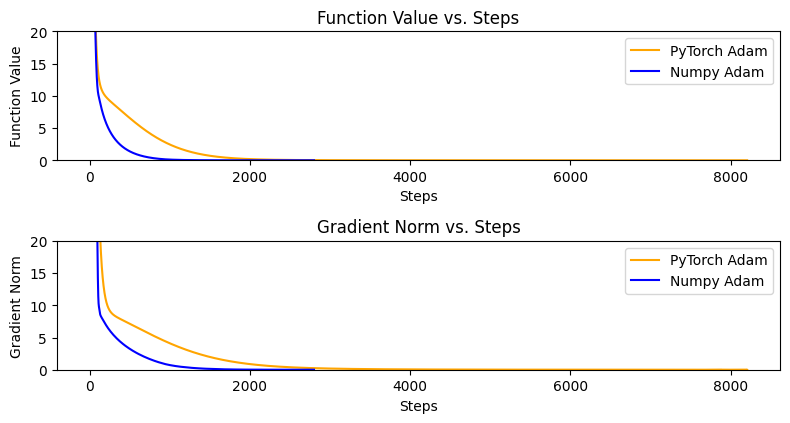

In [ ]:

compare_optimizers(np_results, (torch_loss_history, torch_grad_norms), y_lim = 20)

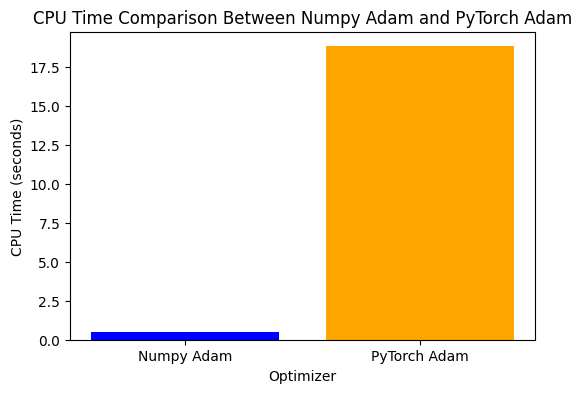

In [ ]:
plot_cpu_time_comparison(cpu_time, cpu_time_torch)

## Rosenbrock

In [ ]:
start_time = time.process_time()
x_init = [0.0, 0.0]
x_opt, total_steps, func_history, grad_norms = adam_optimizer(
    grad_fn=grad_rosenbrock,
    func_fn=rosenbrock,
    x_init=x_init
)
np_results = (x_opt, total_steps, func_history, grad_norms)
end_time = time.process_time()

# Calculate the CPU time used
cpu_time = end_time - start_time


print(f"Optimized parameters: {x_opt}")
print(f"Total steps: {total_steps}")



Step 1: Function value = 0.980297, Gradient norm = 2.000000
Step 2: Function value = 0.965727, Gradient norm = 1.979907
Step 3: Function value = 0.942234, Gradient norm = 2.441130
Step 4: Function value = 0.926863, Gradient norm = 1.946607
Step 5: Function value = 0.909481, Gradient norm = 2.148772
Step 6: Function value = 0.889715, Gradient norm = 2.167601
Step 7: Function value = 0.870831, Gradient norm = 1.965905
Step 8: Function value = 0.854062, Gradient norm = 1.851174
Step 9: Function value = 0.837911, Gradient norm = 1.949689
Step 10: Function value = 0.821051, Gradient norm = 2.048429
Step 11: Function value = 0.804146, Gradient norm = 1.988753
Step 12: Function value = 0.788343, Gradient norm = 1.834108
Step 13: Function value = 0.773518, Gradient norm = 1.733788
Step 14: Function value = 0.758592, Gradient norm = 1.730503
Step 15: Function value = 0.743188, Gradient norm = 1.727376
Step 16: Function value = 0.727746, Gradient norm = 1.680892
Step 17: Function value = 0.71280

In [ ]:
print(f"CPU time used: {round(cpu_time, 3)} seconds")

CPU time used: 0.299 seconds


In [ ]:
import torch


start_time = time.process_time()
# Initialize parameters
x = torch.tensor([-1.2, 1.0], requires_grad=True)  # Starting point

# Optimizer
optimizer = torch.optim.Adam([x], lr=0.01)  # Using Adam optimizer
epsilon = 1e-3  # Convergence threshold
steps = 0

# Storage for plotting
torch_loss_history = []
torch_grad_norms = []


# Optimization loop
while True:
    steps += 1
    optimizer.zero_grad()  # Clear gradients
    loss = rosenbrock(x)  # Compute loss (function value)
    loss.backward()  # Compute gradients
    # Store values
    torch_loss_history.append(loss.item())
    grad_norm = torch.norm(x.grad).item()
    torch_grad_norms.append(grad_norm)


    optimizer.step()  # Update parameters

    grad_norm = torch.norm(x.grad)  # Compute gradient norm
    print(f"At step {steps}, function value is {loss.item():.6f}, grad norm is {grad_norm:.6f}")

    # Check convergence
    if grad_norm < epsilon:
        break
print(f"Optimized parameters: {x.detach().numpy()}")
end_time = time.process_time()

# Calculate the CPU time used
cpu_time_torch = end_time - start_time



At step 1, function value is 24.200005, grad norm is 232.867722
At step 2, function value is 21.287834, grad norm is 213.718353
At step 3, function value is 18.628498, grad norm is 194.981323
At step 4, function value is 16.221302, grad norm is 176.694824
At step 5, function value is 14.063983, grad norm is 158.898605
At step 6, function value is 12.152567, grad norm is 141.633896
At step 7, function value is 10.481194, grad norm is 124.943008
At step 8, function value is 9.042027, grad norm is 108.869202
At step 9, function value is 7.825152, grad norm is 93.456093
At step 10, function value is 6.818575, grad norm is 78.747780
At step 11, function value is 6.008183, grad norm is 64.787010
At step 12, function value is 5.377915, grad norm is 51.615597
At step 13, function value is 4.909942, grad norm is 39.273178
At step 14, function value is 4.584990, grad norm is 27.797663
At step 15, function value is 4.382759, grad norm is 17.230095
At step 16, function value is 4.282411, grad norm

In [ ]:
print(f"CPU time used: {round(cpu_time_torch, 3)} seconds")

CPU time used: 6.485 seconds


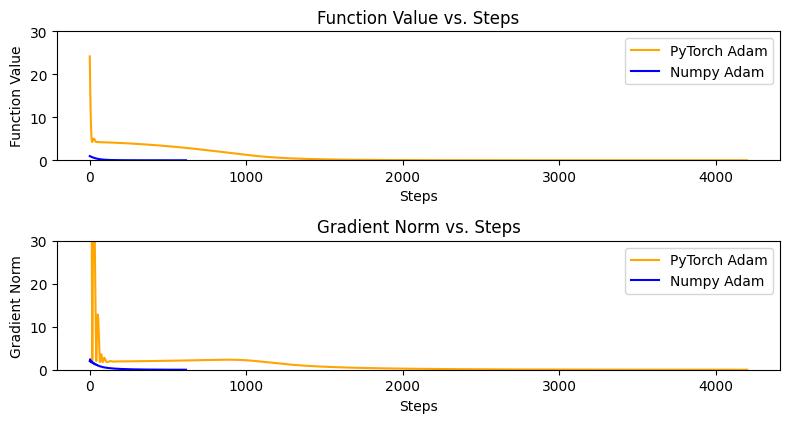

In [ ]:

compare_optimizers(np_results, (torch_loss_history, torch_grad_norms), y_lim = 30)

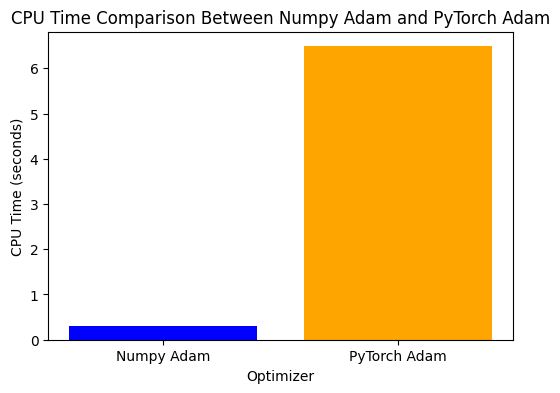

In [ ]:
plot_cpu_time_comparison(cpu_time, cpu_time_torch)